In [1]:
import os, pathlib

In [4]:
org_dir = pathlib.Path("train")
new_dir = pathlib.Path("cats_dogs")
import shutil
def make_subset(subset_name, start, end):
    for category in ("cat", "dog"):
        dir = new_dir / subset_name / category
        os.makedirs(dir)
        filenames = [f"{category}.{i}.jpg" for i in range(start, end)]
        
        for f_name in filenames:
            shutil.copyfile(src = org_dir / f_name, dst = dir / f_name)

make_subset("train", 0, 1000)
make_subset("validation", 1000, 1500)
make_subset("test", 1500, 2500)

In [12]:
from tensorflow import keras
from keras import layers
import keras
inputs = keras.Input(shape=(180,180,3))
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(.1),
    layers.RandomZoom(.2),
])
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters = 32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2) (x)

In [13]:
x = layers.Conv2D(filters = 64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters = 128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters = 256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters = 256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [15]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

## Data Preprocessing with Keras

Keras comes with image_dataset_from_directory function to easily prepare data

In [16]:
from keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_dir / "train", image_size = (180,180), batch_size = 32
)

validation_set = image_dataset_from_directory(
    new_dir / "validation", image_size = (180,180), batch_size = 32
)

test_set = image_dataset_from_directory(
    new_dir / "test", image_size = (180,180), batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


This preprocessing step generates tf.Data.Dataset from image files in a directory, like PyTorch

In [17]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

A Dataset object is an iterator, for loop can be used to extract data. Typically, it returns batches of input data and labels. 

In [19]:
for data_batch, labels_batch in train_dataset:
    print("Data batch shape: ", data_batch.shape)
    print("Labels batch shape: ", labels_batch.shape)
    break

Data batch shape:  (32, 180, 180, 3)
Labels batch shape:  (32,)


To fit the model on dataset, **validation set** will be used.

In [20]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_from_stratch.keras", save_best_only=True, monitor = "val_loss")]

In [21]:
history = model.fit(
train_dataset,
epochs=30,
validation_data=validation_set,
callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 42s 659ms/step - loss: 0.7345 - accuracy: 0.5060 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 2/30
63/63 [==============================] - 40s 638ms/step - loss: 0.6986 - accuracy: 0.5180 - val_loss: 0.7890 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 41s 652ms/step - loss: 0.7048 - accuracy: 0.5515 - val_loss: 0.8431 - val_accuracy: 0.5390
Epoch 4/30
63/63 [==============================] - 41s 651ms/step - loss: 0.6483 - accuracy: 0.6235 - val_loss: 0.7160 - val_accuracy: 0.5420
Epoch 5/30
63/63 [==============================] - 40s 634ms/step - loss: 0.6128 - accuracy: 0.6565 - val_loss: 0.6295 - val_accuracy: 0.6260
Epoch 6/30
63/63 [==============================] - 40s 636ms/step - loss: 0.5886 - accuracy: 0.6900 - val_loss: 0.8040 - val_accuracy: 0.6040
Epoch 7/30
63/63 [==============================] - 40s 637ms/step - loss: 0.5496 - accuracy: 0.7210 - val_loss: 0.6002 - val_accuracy: 0.6890

<Figure size 432x288 with 0 Axes>

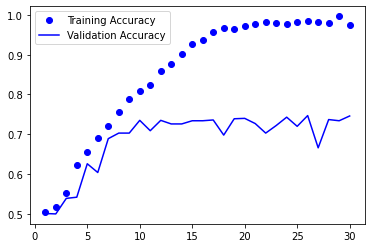

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
accuracy  = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label = "Validation Accuracy" )

plt.legend()
plt.figure()

Data Augmentation

When you have few training samples, better to use Data Augmentation. You may also reduce overfitting by using weight decay (L2 Regularization) or dropout.

### Leveraging PreTrained Model

On small image datasets, using pretrained models performs well. There are two ways to use a pretrained model: Feature Extraction and Fine-Tuning

In [23]:
test_model = keras.models.load_model("convnet_from_stratch.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Acc: {test_acc} ")

63/63 [==============================] - 9s 136ms/step - loss: 0.5588 - accuracy: 0.7445
Acc: 0.7444999814033508 
